# Bowtie2

## 0. Разбораться с Bowtie2 
Построить индекс, запустить Bowtie2 на тестовых данных, определить процент приложившихся ридов. 

In [ ]:
! bowtie2-build /Johnny/students/NGS/data/4/E.coli/MG1655-K12.first10K.fasta ecoli10K

In [3]:
! bowtie2 --fr -x ecoli10K -1 /Johnny/students/NGS/data/4/E.coli/test_1.fastq -2 /Johnny/students/NGS/data/4/E.coli/test_2.fastq > test.sam

28160 reads; of these:
  28160 (100.00%) were paired; of these:
    0 (0.00%) aligned concordantly 0 times
    28160 (100.00%) aligned concordantly exactly 1 time
    0 (0.00%) aligned concordantly >1 times
    ----
    0 pairs aligned concordantly 0 times; of these:
      0 (0.00%) aligned discordantly 1 time
    ----
    0 pairs aligned 0 times concordantly or discordantly; of these:
      0 mates make up the pairs; of these:
        0 (0.00%) aligned 0 times
        0 (0.00%) aligned exactly 1 time
        0 (0.00%) aligned >1 times
100.00% overall alignment rate


In [ ]:
! bowtie2-build /Johnny/students/NGS/data/4/E.coli/MG1655-K12.fasta ecoli

In [2]:
! bowtie2 --fr -x ecoli -1 /Johnny/students/NGS/data/4/E.coli/ecoli_mda_lane1_left.fastq.00.cor.fastq -2 /Johnny/students/NGS/data/4/E.coli/ecoli_mda_lane1_right.fastq.00.cor.fastq > ecoli_mda.sam

14196256 reads; of these:
  14196256 (100.00%) were paired; of these:
    1356988 (9.56%) aligned concordantly 0 times
    12398883 (87.34%) aligned concordantly exactly 1 time
    440385 (3.10%) aligned concordantly >1 times
    ----
    1356988 pairs aligned concordantly 0 times; of these:
      538532 (39.69%) aligned discordantly 1 time
    ----
    818456 pairs aligned 0 times concordantly or discordantly; of these:
      1636912 mates make up the pairs; of these:
        1288294 (78.70%) aligned 0 times
        297803 (18.19%) aligned exactly 1 time
        50815 (3.10%) aligned >1 times
95.46% overall alignment rate


In [4]:
! bowtie2 --fr -x ecoli -1 /Johnny/students/NGS/data/4/E.coli/s_6_1.fastq -2 /Johnny/students/NGS/data/4/E.coli/s_6_2.fastq > s6.sam

14214324 reads; of these:
  14214324 (100.00%) were paired; of these:
    121344 (0.85%) aligned concordantly 0 times
    13720474 (96.53%) aligned concordantly exactly 1 time
    372506 (2.62%) aligned concordantly >1 times
    ----
    121344 pairs aligned concordantly 0 times; of these:
      3368 (2.78%) aligned discordantly 1 time
    ----
    117976 pairs aligned 0 times concordantly or discordantly; of these:
      235952 mates make up the pairs; of these:
        144142 (61.09%) aligned 0 times
        86107 (36.49%) aligned exactly 1 time
        5703 (2.42%) aligned >1 times
99.49% overall alignment rate


## 1. Покрытие генома.
По SAM файлу построить график покрытия генома, определить среднее покрытие и долю покрытой области генома. Покрытие одной позиции в геноме есть количество ридов, приложившихся так, что их концы находятся по разные стороны от этой позиции. График можно строить усредняя, например, по 1000 нуклеотидов. Доля покрытой области генома определяется как процент нуклеотидов с ненулевым покрытием по отношению ко всей длине генома.

getCover принимает путь до sam файла и возвращает список, где для каждой позиции указано количество, покрывающих эту позицию ридов. Что бы узнать ответ, перебираем все риды, прибавляем 1 при открытие рида, вычаем при закрытие и считаем сумму на префиксе. 

In [8]:
import pysam

def getCover(filename):
    samfile = pysam.AlignmentFile(filename, "r")
    reflen = samfile.header.get("SQ")[0]['LN']
    
    cover = [0]*(reflen + 1)
    
    for record in samfile.fetch():
        if not record.is_unmapped:
            rpos = record.reference_start
            rlen = record.reference_length
            cover[rpos] += 1
            cover[rpos + rlen] -= 1
    
    for i in range(1, reflen):
        cover[i] += cover[i - 1]
    return cover

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  

def showCover(filename):
    cover = getCover(filename)
    print("Average coverage: " + str(sum(cover)/len(cover)))
    print("Coverage rate: " + str((len(cover) - cover.count(0))/len(cover)))
    avcover = [0]*(len(cover)//1000 + 1)
    x = [i for i in range(0, len(cover), 1000)]
    for i in range(len(cover)):
        avcover[i//1000] += cover[i]
    for i in range(len(avcover) - 1):
        avcover[i] /= 1000
    avcover = avcover[:-1]
    x = x[:len(avcover)]
    
    plt.plot(x, avcover)
    plt.axis([0, (len(cover)//1000 - 1)*1000, 0, max(avcover)])
    plt.xlabel('coord')
    plt.ylabel('Coverage')
    plt.title(filename)
    plt.show()

Average coverage: 508.9247075292471
Coverage rate: 1.0


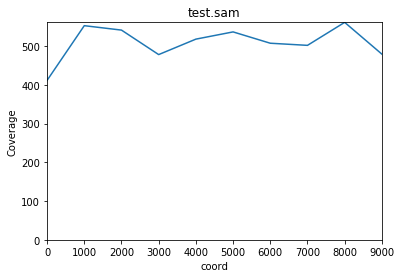

In [6]:
showCover("test.sam")

Average coverage: 523.5052051048392
Coverage rate: 0.9802602595526066


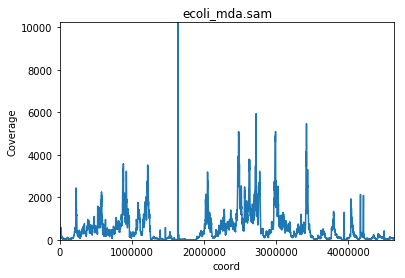

In [14]:
showCover("ecoli_mda.sam")

Выглядит так, как будто эти риды были получены из одной клетки. 

Average coverage: 609.594759634078
Coverage rate: 1.0


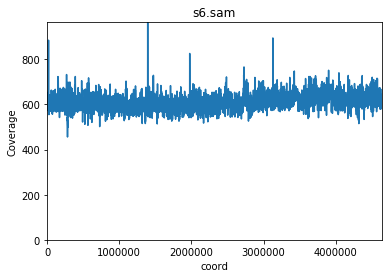

In [15]:
showCover("s6.sam")

In [ ]:
А здесь много клеток. Хорошее и равномерное покрытие. 

## 2. Распределение расстояния вставки.

По SAM файлу построить график распределения расстояния вставки, определить среднее расстояние вставки, среднеквадратичное отклонение и интервал минимальной ширины, в который попадает 95% ридов. На графике по оси Х должно быть расстояние вставки, по оси Y — количество ридов в заданным расстоянием вставки.

In [19]:
def getInsertSize(filename):
    samfile = pysam.AlignmentFile(filename, "r")
    insertSize = []
    
    for record in samfile.fetch():
        if ((not record.is_unmapped) and record.is_paired and record.is_read1):
            rpos = record.reference_start
            rlen = record.reference_length
    
            npos = record.next_reference_start
            if (npos > (rpos + rlen)):
                insertSize.append(npos - (rpos + rlen))
    return insertSize

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

def showInsertSize(filename):
    insertSize = getInsertSize(filename)
    npis = np.array(insertSize)
    print("Average insert size: " + str(np.mean(npis)))
    print("SD insert size: " + str(np.std(npis)))
    insertSize.sort()
    bbg = 0
    cntElem = int(0.95*len(insertSize))
    for bg in range(int(len(insertSize) - 0.95*len(insertSize))):
        if ((insertSize[bg + cntElem] - insertSize[bg]) < insertSize[bbg + cntElem] - insertSize[bbg]):
            bbg = bg
    print("95% seq: " + str(insertSize[bbg]) + "-" + str(insertSize[bbg + cntElem]))
    
    lst = 0
    mx = np.mean(npis) + np.std(npis)**0.5
    for i in range(int(len(insertSize))):
        if (insertSize[i] < mx):
            lst = i
    
    insertSize = insertSize[:lst]
                   
    num_bins = 50
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(insertSize, num_bins)
    
    ax.set_xlabel('Insert size')
    ax.set_ylabel('Reads number')
    ax.set_title(filename)
    ax.set_xlim([0, np.mean(npis) + np.std(npis)**0.5])
    
    fig.tight_layout()
    #mpl.rcParams['figure.figsize'] = (100,100)
    plt.show()

Average insert size: 35.9313761468
SD insert size: 26.2584205269
95% seq: 1-89


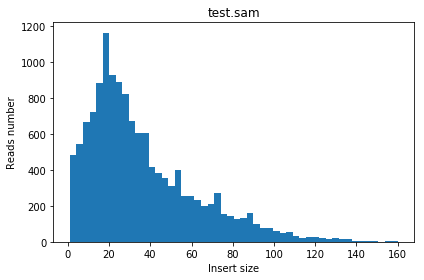

In [34]:
showInsertSize("test.sam")

Average insert size: 26544.0512728
SD insert size: 226241.24428
95% seq: 1-188


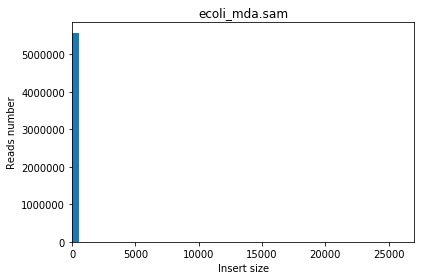

In [33]:
showInsertSize("ecoli_mda.sam")

Average insert size: 418.854978921
SD insert size: 32732.9156273
95% seq: 1-32


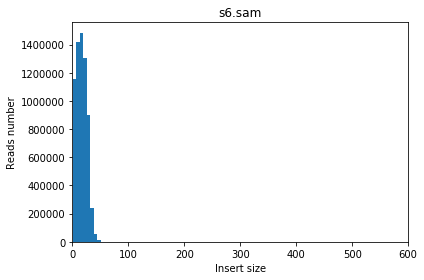

In [34]:
showInsertSize("s6.sam")

Какое-то расстояние вставки очень мелкое получается. Это странно... 

## 3. Частоты различных замен
Построить матрицу частот замен:

| Read\Reference | A | C | G | T |
|----------------|---|---|---|---|
| A              | 0 | 0 | 0 | 0 |
| C              | 0 | 0 | 0 | 0 |
| G              | 0 | 0 | 0 | 0 |
| T              | 0 | 0 | 0 | 0 |


Так, в ячейке (А,С) должно стоять количество ошибок замены С на А (С в референсе, А в риде).

In [54]:
from Bio import SeqIO

def getLetId(c, isrv):
    #print(c)
    let = ["ACGTN", "TGCAN"]
    for i in range(5):
        if (let[isrv][i] == c):
            return i
        
def getReplacementMatrix(reffilename, samfilename):
    for rec in SeqIO.parse(reffilename, "fasta"): 
        ref = rec.seq 
    
    samfile = pysam.AlignmentFile(samfilename, "r")
    res = [[0]*5 for i in range(5)]
    let = "ACGTN"
    
    for record in samfile.fetch():
        if record.is_unmapped:
            continue
        cigar = record.cigartuples
        rpos = record.reference_start
        seq = record.query_sequence
        spos = 0
        for i in range(len(cigar)):
            if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
                cntl = cigar[i][1]
                isrv = 0#record.is_reverse
                for j in range(cntl):
                    res[getLetId(seq[spos + j], isrv)][getLetId(ref[rpos + j], 0)] += 1
                rpos += cigar[i][1]
                spos += cigar[i][1]
            elif (cigar[i][0] == 1 or cigar[i][0] == 4):
                spos += cigar[i][1]
            elif (cigar[i][0] == 2 or cigar[i][0] == 3):
                rpos += cigar[i][1]
    samfile.close()
    res = res[:4]
    for i in range(4):
        res[i] = res[i][:4]
    return res  

In [51]:
import pandas as pd

res = getReplacementMatrix("/Johnny/students/NGS/data/4/E.coli/MG1655-K12.first10K.fasta", "test.sam")

df = pd.DataFrame(data=res, columns=['A', 'C', 'G', 'T'], index=['A', 'C', 'G', 'T'])
print(df)
    

         A        C        G        T
A  1273179        0        0        0
C       15  1265932       22        1
G       20        2  1366979       17
T        1        2       34  1183555


In [55]:
res = getReplacementMatrix("/Johnny/students/NGS/data/4/E.coli/MG1655-K12.fasta", "ecoli_mda.sam")
df = pd.DataFrame(data=res, columns=['A', 'C', 'G', 'T'], index=['A', 'C', 'G', 'T'])
print(df)

           A          C          G          T
A  622315496     298873     211233     245857
C     477135  596714022     239574     349332
G     355494     240886  586981296     476972
T     247200     220802     298382  616765304


In [56]:
res = getReplacementMatrix("/Johnny/students/NGS/data/4/E.coli/MG1655-K12.fasta", "s6.sam")

df = pd.DataFrame(data=res, columns=['A', 'C', 'G', 'T'], index=['A', 'C', 'G', 'T'])
print(df)

           A          C          G          T
A  688065788    3123636    2022728    1876081
C    6271801  705288580    3588515    4280292
G    4307414    3590942  703389803    6261041
T    1868360    2001216    3125767  687363464


Из хорошего, здесь само собой получается что частота замен с->A такая же как G->T условно. То есть если заменить буковки на комплементарные, то частота сама собой будет примерно такая же. Это хорошо. А в остальном как-то не очень логично. То есть мне не понятно, почему замена C->A(G->T) такая популярная, мне кажется было бы логичнее если бы Пурины заменялись на Пурины, а Пиримидины на пирамидины, но нет. Причем популярность замен во всех случаях примерно сохраняется. 